In [45]:
import sys
import h5py
import numpy as np
import tecplot_io as tec
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import os

In [46]:
def func2(x, a, b):
  return a*x+b

def find_index(_z, _limits):
  _n = len(_z)
  _i_min = 0
  _i_max = _n - 1
  _limits2 = np.zeros(2)
  if isinstance(_limits, float):
    _limits2[0:2] = _limits
  else:
    _limits2 = _limits
          
  for i in range(_n):
    if _z[i]<_limits2[0] and i>_i_min :
      _i_min = i
    if _z[i]>_limits2[1] and i<_i_max :
      _i_max = i
  #print('zlimits='+str(_limits))
  #print('i_min='+str(_i_min)+', i_max='+str(_i_max))
  
  if isinstance(_limits, float):
    return _i_min
  else:
    return _i_min, _i_max

def diff_central(x, y):
  x0 = x[:-2]
  x1 = x[1:-1]
  x2 = x[2:]
  y0 = y[:-2]
  y1 = y[1:-1]
  y2 = y[2:]
  f = (x2 - x1)/(x2 - x0)
  f1 = (1-f)*(y2 - y1)/(x2 - x1) + f*(y1 - y0)/(x1 - x0)
  f2 = x.copy()
  f2[1:-1] = f1
  f2[0] = f1[0]
  f2[-1] = f1[-1]
  return f2

In [47]:
#kappa = 0.4
#nu = 1.511e-5
#PEX = 1.45444104333
#PEY = 8.72664625997
#hbar = 0.46
#uinfty = 2.54390548295
dt = 0.68543297937
#Rotational angular period
T_turb = 42.84
#U_star = 0.356
U_star = 0.45
H_hub = 70
#Mean finite velocity
U = 11.5258407161
tis = 200
tie = 15000
tii = 200
nti = int((tie - tis) / tii + 1)

In [48]:
path = 'd:\post\Project'
casenames = ["Fixed_Turbine", "Pitch_Turbine", "SWAY_Turbine", "SWAY_2302"]
os.chdir(path+'\Fixed_Turbine')
print("Current working directory: {0}".format(os.getcwd()) )
casename_s = 0
casename_e = 4

Current working directory: d:\post\Project\Fixed_Turbine


In [49]:
for it in range(nti):
    ti = tis + tii * it
    time = ti * dt
    fname = 'DAT_{:010d}.h5'.format(ti)
#    print("Reading file "+ fname)
    f = h5py.File(fname, "r")

    #print("Keys: %s" % f.keys())
    ## Old version Keys: [u'dz', u'dzw', u'eta', u'eta0', u'hh', u'pp', u'u', u'v', u'w', u'z', u'zw', u'zz']
    ## New version Keys: [u'eta', u'hh', u'pp', u'u', u'v', u'w', u'z']
    
    zz = np.array(f["z"][:,0,0]).copy()
    u = f["u"]
    v = f["v"]
    w2 = f["w"]
    w = np.array(w2).copy()

#   print(u.shape)

    NPX = u.shape[2]
    NPY = u.shape[1]
    NPZ = u.shape[0]
    
    if it==0:
      u_m_all = np.zeros((NPZ,3))
      uu_m_all = np.zeros((NPZ,6))

    w[0, :, :] = w2[0, :, :]
    for k in range(1,NPZ):
      w[k, :, :] = 0.5*(w2[k-1, :, :] + w2[k, :, :])

    u_m = np.zeros((NPZ,3))
    uu_m1 = np.zeros((NPZ,6))
    uu_m2 = np.zeros((NPZ,6))

    for k in range(NPZ):
      u_m[k, 0] = np.average(u[k,:,:])
      u_m[k, 1] = np.average(v[k,:,:])
      u_m[k, 2] = np.average(w[k,:,:])
      uu_m1[k, 0] = np.average(u[k,:,:]**2)
      uu_m1[k, 1] = np.average(v[k,:,:]**2)
      uu_m1[k, 2] = np.average(w[k,:,:]**2)
      uu_m1[k, 3] = np.average(u[k,:,:]*v[k,:,:])
      uu_m1[k, 4] = np.average(u[k,:,:]*w[k,:,:])
      uu_m1[k, 5] = np.average(v[k,:,:]*w[k,:,:])
      uu_m2[k, 0:3] = uu_m1[k, 0:3] - u_m[k,0:3]**2
      uu_m2[k, 3] = uu_m1[k, 3] - u_m[k, 0] * u_m[k, 1]
      uu_m2[k, 4] = uu_m1[k, 4] - u_m[k, 0] * u_m[k, 2]
      uu_m2[k, 5] = uu_m1[k, 5] - u_m[k, 1] * u_m[k, 2]

    u_m_all = u_m_all + u_m
    uu_m_all = uu_m_all + uu_m2

    mean_flux = np.trapz(u_m[:,0], zz[:])

u_m_all = u_m_all / nti
uu_m_all = uu_m_all / nti


In [50]:
data = np.zeros((NPZ,5))
data[:,0] = zz[:]/H_hub
data[:,1] = (u_m_all[:,0]*U)#/U_star
print("End process directory: {0}".format(os.getcwd()) )

End process directory: d:\post\Project\Fixed_Turbine


In [51]:
#change working directory
os.chdir(path+'\Pitch_Turbine')
print("Current working directory: {0}".format(os.getcwd()) )

Current working directory: d:\post\Project\Pitch_Turbine


In [52]:
for it in range(nti):
    ti = tis + tii * it
    time = ti * dt
    fname = 'DAT_{:010d}.h5'.format(ti)
#    print("Reading file "+ fname)
    f = h5py.File(fname, "r")

    #print("Keys: %s" % f.keys())
    ## Old version Keys: [u'dz', u'dzw', u'eta', u'eta0', u'hh', u'pp', u'u', u'v', u'w', u'z', u'zw', u'zz']
    ## New version Keys: [u'eta', u'hh', u'pp', u'u', u'v', u'w', u'z']
    
    zz = np.array(f["z"][:,0,0]).copy()
    u = f["u"]
    v = f["v"]
    w2 = f["w"]
    w = np.array(w2).copy()

#   print(u.shape)

    NPX = u.shape[2]
    NPY = u.shape[1]
    NPZ = u.shape[0]
    
    if it==0:
      u_m_all = np.zeros((NPZ,3))
      uu_m_all = np.zeros((NPZ,6))

    w[0, :, :] = w2[0, :, :]
    for k in range(1,NPZ):
      w[k, :, :] = 0.5*(w2[k-1, :, :] + w2[k, :, :])

    u_m = np.zeros((NPZ,3))
    uu_m1 = np.zeros((NPZ,6))
    uu_m2 = np.zeros((NPZ,6))

    for k in range(NPZ):
      u_m[k, 0] = np.average(u[k,:,:])
      u_m[k, 1] = np.average(v[k,:,:])
      u_m[k, 2] = np.average(w[k,:,:])
      uu_m1[k, 0] = np.average(u[k,:,:]**2)
      uu_m1[k, 1] = np.average(v[k,:,:]**2)
      uu_m1[k, 2] = np.average(w[k,:,:]**2)
      uu_m1[k, 3] = np.average(u[k,:,:]*v[k,:,:])
      uu_m1[k, 4] = np.average(u[k,:,:]*w[k,:,:])
      uu_m1[k, 5] = np.average(v[k,:,:]*w[k,:,:])
      uu_m2[k, 0:3] = uu_m1[k, 0:3] - u_m[k,0:3]**2
      uu_m2[k, 3] = uu_m1[k, 3] - u_m[k, 0] * u_m[k, 1]
      uu_m2[k, 4] = uu_m1[k, 4] - u_m[k, 0] * u_m[k, 2]
      uu_m2[k, 5] = uu_m1[k, 5] - u_m[k, 1] * u_m[k, 2]

    u_m_all = u_m_all + u_m
    uu_m_all = uu_m_all + uu_m2

    mean_flux = np.trapz(u_m[:,0], zz[:])

u_m_all = u_m_all / nti
uu_m_all = uu_m_all / nti

In [53]:
#I made a mistake here. I set the different NPZ among ather cases. 
#So I will use u_m_all[1:,0] instead.
#I will update it later.
data[:,2] = (u_m_all[:64,0]*U)#/U_star
print("End process directory: {0}".format(os.getcwd()) )
os.chdir(path+'\SWAY_Turbine')
print("Current working directory: {0}".format(os.getcwd()) )

End process directory: d:\post\Project\Pitch_Turbine
Current working directory: d:\post\Project\SWAY_Turbine


In [54]:
for it in range(nti):
    ti = tis + tii * it
    time = ti * dt
    fname = 'DAT_{:010d}.h5'.format(ti)
#    print("Reading file "+ fname)
    f = h5py.File(fname, "r")

    #print("Keys: %s" % f.keys())
    ## Old version Keys: [u'dz', u'dzw', u'eta', u'eta0', u'hh', u'pp', u'u', u'v', u'w', u'z', u'zw', u'zz']
    ## New version Keys: [u'eta', u'hh', u'pp', u'u', u'v', u'w', u'z']
    
    zz = np.array(f["z"][:,0,0]).copy()
    u = f["u"]
    v = f["v"]
    w2 = f["w"]
    w = np.array(w2).copy()

#   print(u.shape)

    NPX = u.shape[2]
    NPY = u.shape[1]
    NPZ = u.shape[0]
    
    if it==0:
      u_m_all = np.zeros((NPZ,3))
      uu_m_all = np.zeros((NPZ,6))

    w[0, :, :] = w2[0, :, :]
    for k in range(1,NPZ):
      w[k, :, :] = 0.5*(w2[k-1, :, :] + w2[k, :, :])

    u_m = np.zeros((NPZ,3))
    uu_m1 = np.zeros((NPZ,6))
    uu_m2 = np.zeros((NPZ,6))

    for k in range(NPZ):
      u_m[k, 0] = np.average(u[k,:,:])
      u_m[k, 1] = np.average(v[k,:,:])
      u_m[k, 2] = np.average(w[k,:,:])
      uu_m1[k, 0] = np.average(u[k,:,:]**2)
      uu_m1[k, 1] = np.average(v[k,:,:]**2)
      uu_m1[k, 2] = np.average(w[k,:,:]**2)
      uu_m1[k, 3] = np.average(u[k,:,:]*v[k,:,:])
      uu_m1[k, 4] = np.average(u[k,:,:]*w[k,:,:])
      uu_m1[k, 5] = np.average(v[k,:,:]*w[k,:,:])
      uu_m2[k, 0:3] = uu_m1[k, 0:3] - u_m[k,0:3]**2
      uu_m2[k, 3] = uu_m1[k, 3] - u_m[k, 0] * u_m[k, 1]
      uu_m2[k, 4] = uu_m1[k, 4] - u_m[k, 0] * u_m[k, 2]
      uu_m2[k, 5] = uu_m1[k, 5] - u_m[k, 1] * u_m[k, 2]

    u_m_all = u_m_all + u_m
    uu_m_all = uu_m_all + uu_m2

    mean_flux = np.trapz(u_m[:,0], zz[:])

u_m_all = u_m_all / nti
uu_m_all = uu_m_all / nti

In [55]:
data[:,3] = (u_m_all[:,0]*U)#/U_star
print("End process directory: {0}".format(os.getcwd()) )
#change working directory
os.chdir(path+'\Fixed_no_swell')
print("Current working directory: {0}".format(os.getcwd()) )


End process directory: d:\post\Project\SWAY_Turbine
Current working directory: d:\post\Project\Fixed_no_swell


In [56]:
for it in range(nti):
    ti = tis + tii * it
    time = ti * dt
    fname = 'DAT_{:010d}.h5'.format(ti)
#    print("Reading file "+ fname)
    f = h5py.File(fname, "r")

    #print("Keys: %s" % f.keys())
    ## Old version Keys: [u'dz', u'dzw', u'eta', u'eta0', u'hh', u'pp', u'u', u'v', u'w', u'z', u'zw', u'zz']
    ## New version Keys: [u'eta', u'hh', u'pp', u'u', u'v', u'w', u'z']
    
    zz = np.array(f["z"][:,0,0]).copy()
    u = f["u"]
    v = f["v"]
    w2 = f["w"]
    w = np.array(w2).copy()

#   print(u.shape)

    NPX = u.shape[2]
    NPY = u.shape[1]
    NPZ = u.shape[0]
    
    if it==0:
      u_m_all = np.zeros((NPZ,3))
      uu_m_all = np.zeros((NPZ,6))

    w[0, :, :] = w2[0, :, :]
    for k in range(1,NPZ):
      w[k, :, :] = 0.5*(w2[k-1, :, :] + w2[k, :, :])

    u_m = np.zeros((NPZ,3))
    uu_m1 = np.zeros((NPZ,6))
    uu_m2 = np.zeros((NPZ,6))

    for k in range(NPZ):
      u_m[k, 0] = np.average(u[k,:,:])
      u_m[k, 1] = np.average(v[k,:,:])
      u_m[k, 2] = np.average(w[k,:,:])
      uu_m1[k, 0] = np.average(u[k,:,:]**2)
      uu_m1[k, 1] = np.average(v[k,:,:]**2)
      uu_m1[k, 2] = np.average(w[k,:,:]**2)
      uu_m1[k, 3] = np.average(u[k,:,:]*v[k,:,:])
      uu_m1[k, 4] = np.average(u[k,:,:]*w[k,:,:])
      uu_m1[k, 5] = np.average(v[k,:,:]*w[k,:,:])
      uu_m2[k, 0:3] = uu_m1[k, 0:3] - u_m[k,0:3]**2
      uu_m2[k, 3] = uu_m1[k, 3] - u_m[k, 0] * u_m[k, 1]
      uu_m2[k, 4] = uu_m1[k, 4] - u_m[k, 0] * u_m[k, 2]
      uu_m2[k, 5] = uu_m1[k, 5] - u_m[k, 1] * u_m[k, 2]

    u_m_all = u_m_all + u_m
    uu_m_all = uu_m_all + uu_m2

    mean_flux = np.trapz(u_m[:,0], zz[:])

u_m_all = u_m_all / nti
uu_m_all = uu_m_all / nti

In [57]:
data[:,4] = (u_m_all[:,0]*U)#/U_star
print("End process directory: {0}".format(os.getcwd()) )

End process directory: d:\post\Project\Fixed_no_swell


visualize data


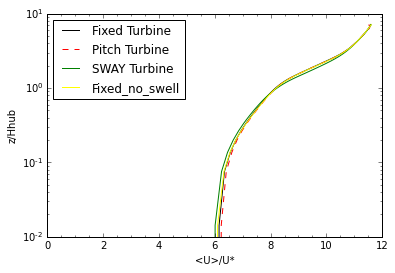

In [61]:
print("visualize data")
%matplotlib inline
#plt.style.use('classic')
fig, ax = plt.subplots()
plt.plot(data[:,1], data[:,0], data[:,2], data[:,0], data[:,3], data[:,0], data[:,4], data[:,0]) 
plt.gca().get_lines()[0].set_color("black")
plt.gca().get_lines()[1].set_color("red")
plt.gca().get_lines()[2].set_color("green")
plt.gca().get_lines()[3].set_color("yellow")
plt.gca().get_lines()[0].set_linestyle("-")
plt.gca().get_lines()[1].set_linestyle("--")
plt.gca().get_lines()[2].set_linestyle("--")
plt.gca().get_lines()[2].set_linestyle("-")
plt.ylabel('z/Hhub')
plt.xlabel('<U>/U*')
plt.legend(["Fixed Turbine", "Pitch Turbine", "SWAY Turbine", "Fixed_no_swell"], loc='upper left')
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
#set minor tick
plt.yscale('log')
plt.show()

In [59]:
#Store data to outputfile
print("Store data to outputfile")
print("End!!!")
path = 'd:\post'
os.chdir(path)

outputfolder = 'post_result/'
#create output folder named 'post_result' 
if not os.path.exists(outputfolder):
    os.makedirs(outputfolder)
print("Current working directory: {0}".format(os.getcwd()))
#np.savetxt('power_density.dat', data)
f = open( outputfolder + "mean velocity profile.plt",'w')
f.write("VARIABLES = t/T, Fixed, Pitch, SWAY  \n")
np.savetxt(f, data)
f.close()

Store data to outputfile
End!!!
Current working directory: d:\post
